In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [10]:
# Creating database connection
conn = sqlite3.connect('inventory.db')

# Fetching vendor summary data
df = pd.read_sql_query("SELECT * FROM vendor_sales_summary", conn)

# Displaying the first few rows
df.head()


,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5101919.51,672819.31,260999.20,68601.68
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4819073.49,561512.37,294438.66,144929.24
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4538120.60,461140.15,343854.07,123780.22
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4475972.88,420050.01,368242.80,257032.07
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4223107.62,545778.28,249587.83,257032.07


In [12]:
#summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,10650.649458,18753.519148,2.00,3951.0000,7153.000,9552.0000,201359.00
Brand,10692.0,18039.228769,12662.187074,58.00,5793.5000,18761.500,25514.2500,90631.00
PurchasePrice,10692.0,24.385303,109.269375,0.36,6.8400,10.455,19.4825,5681.81
ActualPrice,10692.0,35.643671,148.246016,0.49,10.9900,15.990,28.9900,7499.99
Volume,10692.0,847.360550,664.309212,50.00,750.0000,750.000,750.0000,20000.00
TotalPurchaseQuantity,10692.0,3140.886831,11095.086769,1.00,36.0000,262.000,1975.7500,337660.00
TotalPurchaseDollars,10692.0,30106.693372,123067.799627,0.71,453.4575,3655.465,20738.2450,3811251.60
TotalSalesQuantity,10692.0,3077.482136,10952.851391,0.00,33.0000,261.000,1929.2500,334939.00
TotalSalesDollars,10692.0,42239.074419,167655.265984,0.00,729.2200,5298.045,28396.9150,5101919.51
TotalSalesPrice,10692.0,18793.783627,44952.773386,0.00,289.7100,2857.800,16059.5625,672819.31


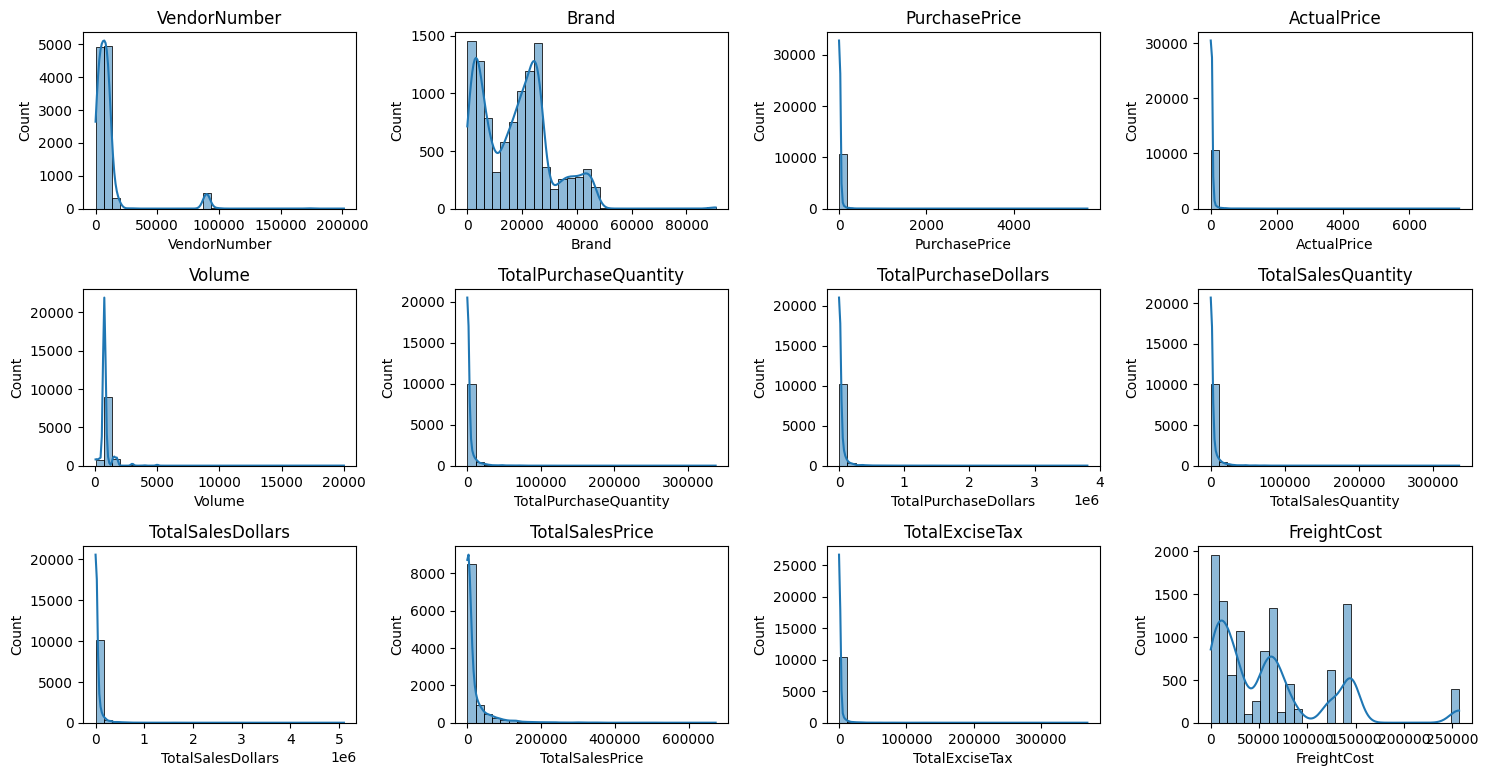

In [13]:
#Distribution Plots for Numerical Columns
numerical_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1) # Adjust grid layout as needed
    sns.histplot(df [col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

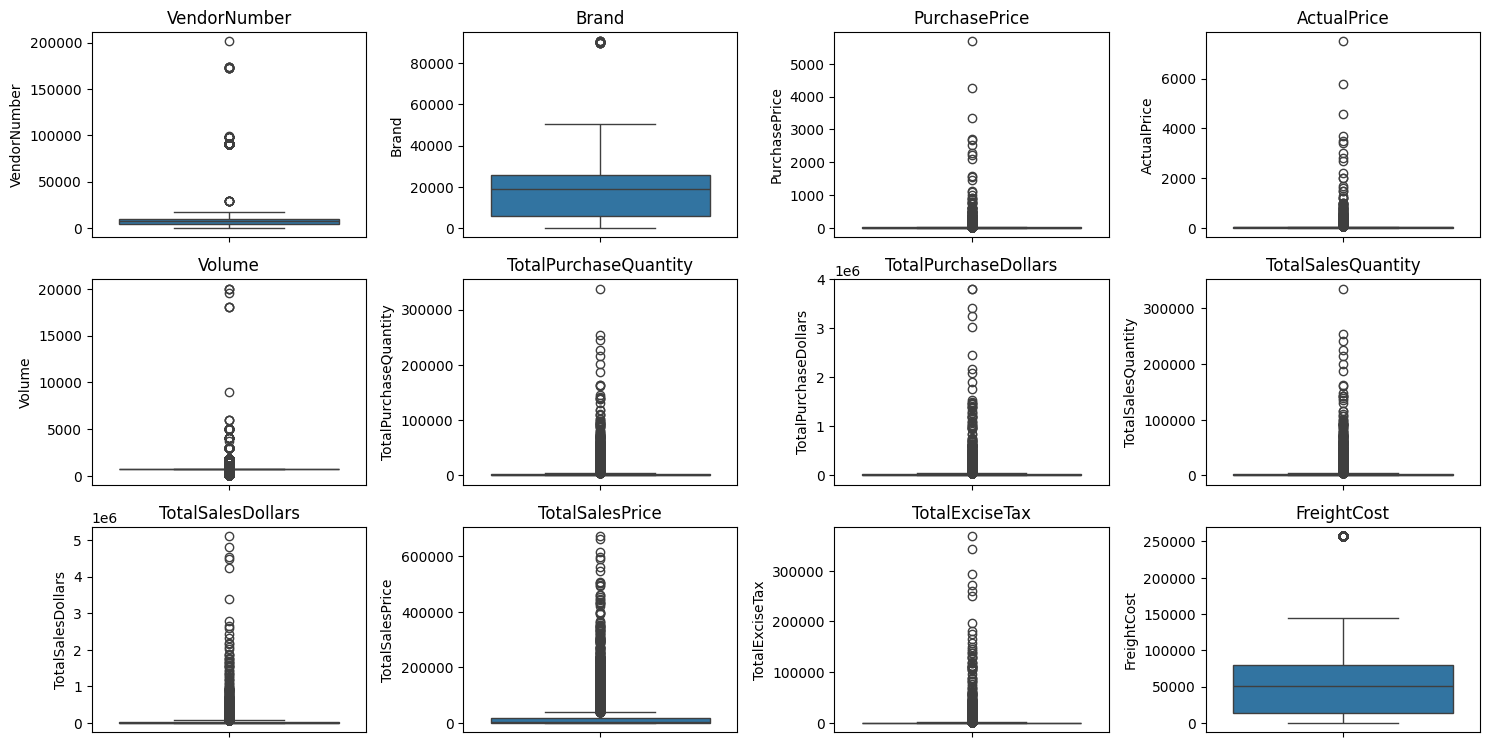

In [21]:
# Outlier Detection with Boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [16]:
##Summary Statistics Insights:
#Negative & Zero Values:
#Gross Profit: Minimum value is -52,002.78, indicating losses. Some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price..
#Profit Margin: Has a minimum of -∞, which suggests cases where revenue is zero or even lower than costs.
#Total Sales Quantity & Sales Dollars: Minimum values are 0, meaning some products were purchased but never sold. These could be slow-moving or obsolete stock.
#Outliers Indicated by High Standard Deviations:
#Purchase & Actual Prices: The max values (5,681.81 & 7,499.99) are significantly higher than the mean (24.39 & 35.64), indicating potential premium products.
#Freight Cost: Huge variation, from 0.09 to 257,032.07, suggests logistics inefficiencies or bulk shipments.
#Stock Turnover: Ranges from 0 to 274.5, implying some products sell extremely fast while others remain in stock indefinitely. Value more than 1 indicates that Sold quantity for that product is higher than purchased quantity due to either sales are being fulfilled from older stock.

In [18]:
df['GrossProfit'] = df['TotalSalesDollars'] - df['TotalPurchaseDollars']
df['ProfitMargin'] = (df['GrossProfit'] / df['TotalSalesDollars']) * 100
df['StockTurnover'] = df['TotalSalesQuantity'] / df['TotalPurchaseQuantity']
df['SalesToPurchaseRatio'] = df['TotalSalesDollars'] / df['TotalPurchaseDollars']


In [19]:
df.to_sql('vendor_sales_summary', conn, if_exists='replace', index=False)


10692

In [20]:
filtered_df = pd.read_sql_query("""
    SELECT *
    FROM vendor_sales_summary
    WHERE GrossProfit > 0
    AND ProfitMargin > 0
    AND TotalSalesQuantity > 0
""", conn)


In [23]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080,3811251.60,142049.0,5101919.51,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038,3804041.22,160247.0,4819073.49,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407,3418303.68,187140.0,4538120.60,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,201682,3261197.94,200412.0,4475972.88,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,138109,3023206.01,135838.0,4223107.62,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,5.0,15.95,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667
10688,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,134.0,65.66,1.47,7.04,50293.62,63.32,96.436186,22.333333,28.059829
10689,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,2.0,1.98,0.99,0.10,14069.87,0.50,25.252525,1.000000,1.337838
10690,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,72.0,143.28,77.61,15.12,257032.07,141.81,98.974037,72.000000,97.469388


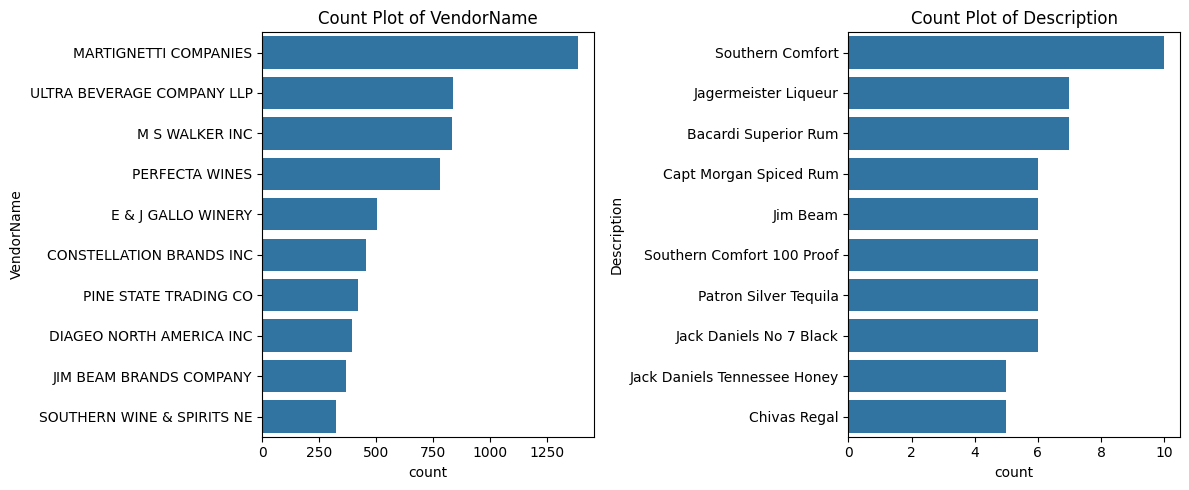

In [24]:
# Count Plots for Categorical Columns
categorical_cols = ["VendorName", "Description"]
plt.figure(figsize=(12,5))
for i, col in enumerate (categorical_cols):
    plt.subplot(1, 2, i+1)
    sns.countplot(y=df[col], order=df [ col].value_counts().index [:10])# Top 10 categories
    plt.title(f"Count Plot of {col}")
plt.tight_layout()
plt.show()

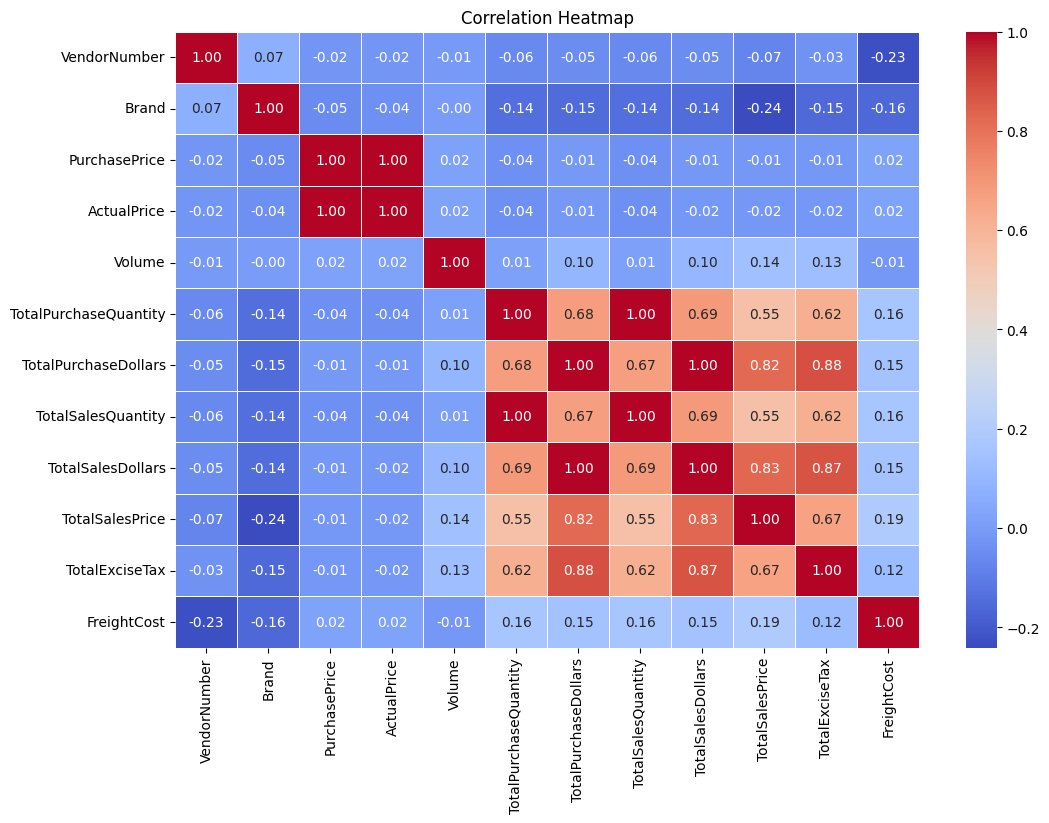

In [26]:
#Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df [numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [27]:
##Correlation Insights
#Purchase Price has weak correlations with TotalSales Dollars (-0.012) and Gross Profit (-0.016), suggesting that price variations do not significantly impact sales revenue or profit.
#Strong correlation between total purchase quantity and total sales quantity (0.999), confirming efficient inventory turnover.
#Negative correlation between profit margin & total sales price (-0.179) suggests that as sales price increases, margins decrease, possibly due to competitive pricing pressures.
#Stock Turnover has weak negative correlations with both GrossProfit (-0.038) and ProfitMargin (-0.055), indicating that faster turnover does not necessarily result in higher profitability.

In [28]:
##Data Analysis
#Identify Brands that needs Promotional or Pricing Adjustment which exhbhit lower sakles performance but higher profit margin

In [32]:
brand_performance=df.groupby('Description').agg({
    'TotalSalesDollars':'sum',
    'ProfitMargin':'mean'
}).reset_index()

In [33]:
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85) 

In [34]:
low_sales_threshold

286.185

In [35]:
high_margin_threshold

56.198056057839054

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thresholds for plotting
high_margin_threshold = 40
low_sales_threshold = 5000

# Define target brands
target_brands = brand_performance[
    (brand_performance['ProfitMargin'] > high_margin_threshold) &
    (brand_performance['TotalSalesDollars'] < low_sales_threshold)
]

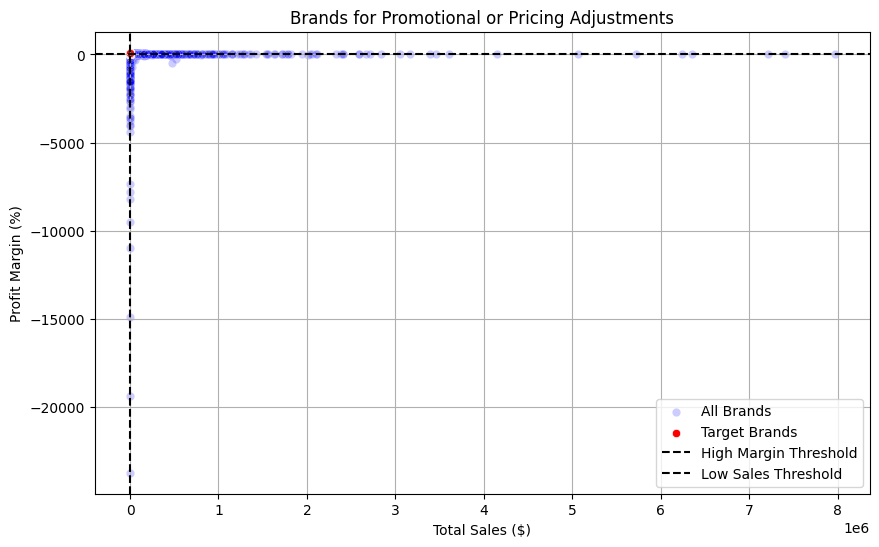

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin',
                color="blue", label="All Brands", alpha=0.2)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin',
                color="red", label="Target Brands")
plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")
plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
def formate_dollars(value):
    if value >=1_000_000:
        return f"{value/1_000_000:.2f}M"
    elif value>= 1_000:
        return f"{value/1_000:2f}K"
    else:
        return str(value)

In [50]:
#which vendor and brand demonstrate the highest sales performance?

top_vendors= df.groupby("VendorName") ["TotalSalesDollars"].sum().nlargest (18)
top_brands= df.groupby("Description") ["TotalSalesDollars"].sum().nlargest(10)
top_vendors

VendorName
DIAGEO NORTH AMERICA INC      68739834.97
MARTIGNETTI COMPANIES         40960117.82
PERNOD RICARD USA             32279544.17
JIM BEAM BRANDS COMPANY       31898621.16
BACARDI USA INC               25005365.79
CONSTELLATION BRANDS INC      24467134.23
E & J GALLO WINERY            18553774.66
BROWN-FORMAN CORP             18476611.60
ULTRA BEVERAGE COMPANY LLP    17802646.10
M S WALKER INC                15436066.26
MOET HENNESSY USA INC         13545179.22
SAZERAC CO INC                13250579.96
PROXIMO SPIRITS INC.          10515302.57
WINE GROUP INC                 8340493.38
PERFECTA WINES                 7779747.03
WILLIAM GRANT & SONS INC       7635228.31
SOUTHERN WINE & SPIRITS NE     5704567.52
CAMPARI AMERICA                5604628.17
Name: TotalSalesDollars, dtype: float64

In [58]:
top_brands

Description
Jack Daniels No 7 Black    7964746.76
Tito's Handmade Vodka      7399657.58
Grey Goose Vodka           7209608.06
Capt Morgan Spiced Rum     6356320.62
Absolut 80 Proof           6244752.03
Jameson Irish Whiskey      5715759.69
Ketel One Vodka            5070083.56
Baileys Irish Cream        4150122.07
Kahlua                     3604858.66
Tanqueray                  3456697.90
Name: TotalSalesDollars, dtype: float64

In [65]:
top_brands.apply(lambda x: formate_dollars(x))

Description
Jack Daniels No 7 Black    7.96M
Tito's Handmade Vodka      7.40M
Grey Goose Vodka           7.21M
Capt Morgan Spiced Rum     6.36M
Absolut 80 Proof           6.24M
Jameson Irish Whiskey      5.72M
Ketel One Vodka            5.07M
Baileys Irish Cream        4.15M
Kahlua                     3.60M
Tanqueray                  3.46M
Name: TotalSalesDollars, dtype: object

In [66]:
def format_dollars(value):
    return f"${value:,.0f}"


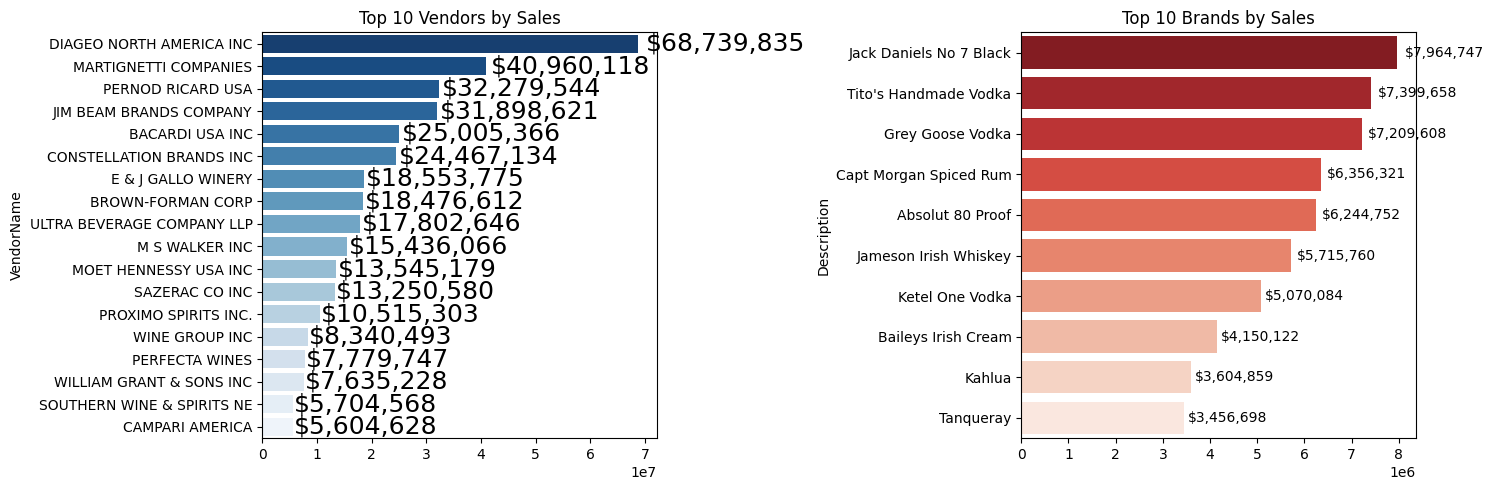

In [67]:
plt.figure(figsize=(15, 5))
#Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 =sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r") 
plt.title("Top 10 Vendors by Sales")
for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width()* 0.02),
             bar.get_y() + bar.get_height() / 2, 
             format_dollars(bar.get_width()), 
             ha='left', va='center', fontsize=18, color='black')
#Plot for Top Brands
plt.subplot(1, 2, 2)
ax2 =sns.barplot(y=top_brands.index.astype(str),x=top_brands.values, palette= "Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),
             bar.get_y() + bar.get_height() / 2, 
             format_dollars(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black')
plt.tight_layout()
plt.show()

In [68]:
#which vendor contribute the most to total purchase dollars?


In [70]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars': 'sum',
    'GrossProfit':'sum',
    'TotalSalesDollars': 'sum'
}).reset_index()

In [73]:
vendor_performance['PurchaseContribution%'] = vendor_performance['TotalPurchaseDollars']/ vendor_performance['TotalPurchaseDollars']

In [74]:
vendor_performance


,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseConribution%,PurchaseContribution%
0,AAPER ALCOHOL & CHEMICAL CO,105.07,-105.07,0.00,1.0,1.0
1,ADAMBA IMPORTS INTL INC,76770.25,-9194.03,67576.22,1.0,1.0
2,ALISA CARR BEVERAGES,34951.68,78638.50,113590.18,1.0,1.0
3,ALTAMAR BRANDS LLC,11706.20,4000.61,15706.81,1.0,1.0
4,AMERICAN SPIRITS EXCHANGE,1205.16,514.81,1719.97,1.0,1.0
...,...,...,...,...,...,...
123,WEIN BAUER INC,43517.00,13413.23,56930.23,1.0,1.0
124,WESTERN SPIRITS BEVERAGE CO,361249.21,81820.99,443070.20,1.0,1.0
125,WILLIAM GRANT & SONS INC,5960744.35,1674483.96,7635228.31,1.0,1.0
126,WINE GROUP INC,5258636.79,3081856.59,8340493.38,1.0,1.0


In [85]:
vendor_performance=vendor_performance.sort_values('PurchaseContribution%',ascending = False)

In [86]:
#Display Top 10 Vendors
top_vendors= vendor_performance.head(10)
top_vendors ['TotalSales Dollars'] = top_vendors ['TotalSalesDollars'].apply(format_dollars)
top_vendors ['TotalPurchase Dollars'] = top_vendors ['TotalPurchaseDollars'].apply(format_dollars)
top_vendors ['GrossProfit'] = top_vendors ['GrossProfit'].apply(format_dollars)
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseConribution%,PurchaseContribution%,TotalSales Dollars,TotalPurchase Dollars
0,AAPER ALCOHOL & CHEMICAL CO,105.07,$-105,0.00,1.0,1.0,$0,$105
1,ADAMBA IMPORTS INTL INC,76770.25,"$-9,194",67576.22,1.0,1.0,"$67,576","$76,770"
94,SOUTHERN WINE & SPIRITS NE,3699813.46,"$2,004,754",5704567.52,1.0,1.0,"$5,704,568","$3,699,813"
93,SOUTHERN GLAZERS W&S OF NE,40803.92,$-364,40440.12,1.0,1.0,"$40,440","$40,804"
92,SMOKY QUARTZ DISTILLERY LLC,69803.71,"$6,645",76449.11,1.0,1.0,"$76,449","$69,804"
91,SILVER MOUNTAIN CIDERS,77.18,$265,342.51,1.0,1.0,$343,$77
90,SIDNEY FRANK IMPORTING CO,1715908.88,"$540,462",2256371.25,1.0,1.0,"$2,256,371","$1,715,909"
89,SHAW ROSS INT L IMP LTD,624979.64,"$231,966",856945.64,1.0,1.0,"$856,946","$624,980"
88,SEA HAGG DISTILLERY LLC,188044.46,"$24,958",213002.55,1.0,1.0,"$213,003","$188,044"
87,SEA BREEZE CELLARS LLC,108948.09,"$40,572",149519.97,1.0,1.0,"$149,520","$108,948"


In [88]:
top_vendors['PurchaseContribution%'].sum()

10.0

In [91]:
# First, ensure top_vendors has TotalPurchaseDollars and VendorName
top_vendors = df.groupby("VendorName")["TotalPurchaseDollars"].sum().sort_values(ascending=False).head(10)

# Convert to DataFrame if it's a Series
top_vendors = top_vendors.reset_index()

# Calculate Purchase Contribution %
total_purchases = top_vendors["TotalPurchaseDollars"].sum()
top_vendors["Purchase_Contribution"] = round((top_vendors["TotalPurchaseDollars"] / total_purchases) * 100, 2)

# Calculate Cumulative Contribution %
top_vendors["Cumulative_Contribution"] = top_vendors["Purchase_Contribution"].cumsum()


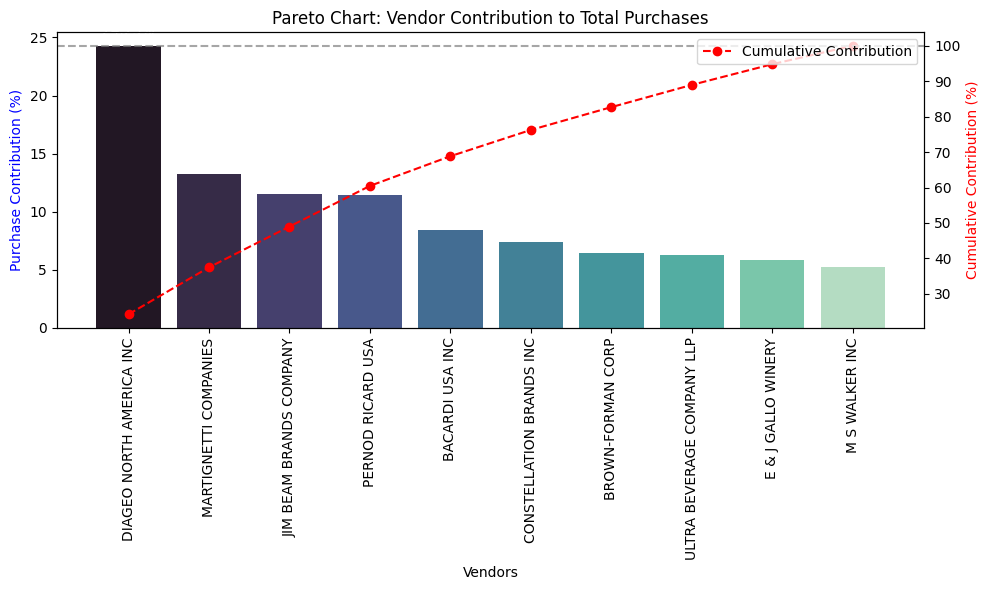

In [92]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contribution
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['Purchase_Contribution'], palette="mako", ax=ax1)
for i, value in enumerate(top_vendors['Purchase_Contribution']):
    ax1.text(i, value + 1, str(value) + '%', ha='center', fontsize=10, color='white')

# Line plot for Cumulative Contribution
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_Contribution'], color='red', marker='o', linestyle='dashed', label='Cumulative Contribution')

# Formatting
ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution (%)', color='blue')
ax2.set_ylabel('Cumulative Contribution (%)', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')
ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [93]:
#How much total Procurement is dependent on the top vendors?

In [95]:
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors['Purchase_Contribution'].sum(), 2)}%")


Total Purchase Contribution of top 10 vendors is 100.0%


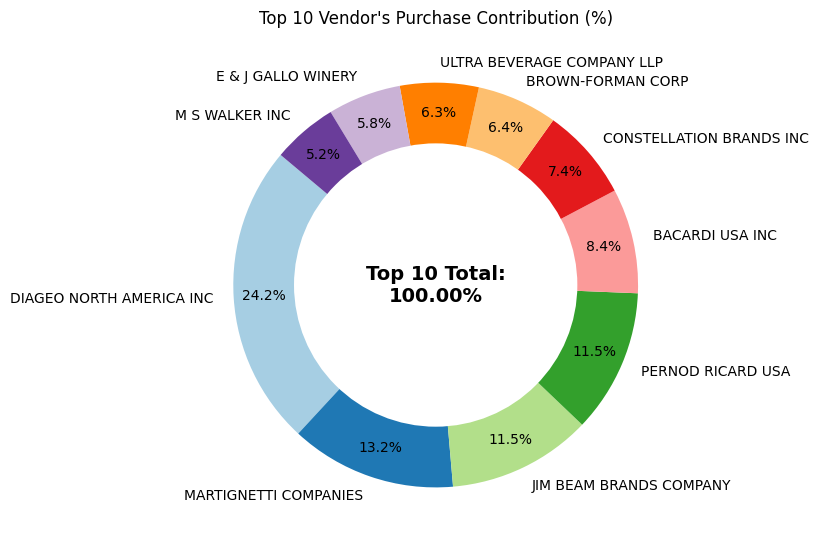

In [98]:
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['Purchase_Contribution'].values)

total_contribution = sum(purchase_contributions)

# Cap the total at 100 and handle rounding errors
remaining_contribution = max(0, 100 - total_contribution)

# Append "Other Vendors" only if space left
if remaining_contribution > 0:
    vendors.append("Other Vendors")
    purchase_contributions.append(remaining_contribution)

# Plot Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    purchase_contributions,
    labels=vendors,
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85,
    colors=plt.cm.Paired.colors
)

# Draw center circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add annotation
plt.text(0, 0, f"Top 10 Total:\n{min(total_contribution, 100):.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.tight_layout()
plt.show()


In [99]:
#Does purchasin in bulk reduce the unit price, and what is the optimal purchase volume for cost saving?

In [100]:
df['UnitPurchasePrice']=df['TotalPurchaseDollars']/df['TotalPurchaseQuantity']

In [103]:
df["OrderSize"]=pd.qcut(df["TotalPurchaseQuantity"],q=3,labels=["Small","Medium","Large"])

In [104]:
df['OrderSize']

0        Large
1        Large
2        Large
3        Large
4        Large
         ...  
10687    Small
10688    Small
10689    Small
10690    Small
10691    Small
Name: OrderSize, Length: 10692, dtype: category
Categories (3, object): ['Small' < 'Medium' < 'Large']

In [105]:
df.groupby('OrderSize')[["UnitPurchasePrice"]].mean()

,UnitPurchasePrice
OrderSize,
Small,43.776954
Medium,17.894005
Large,11.308807


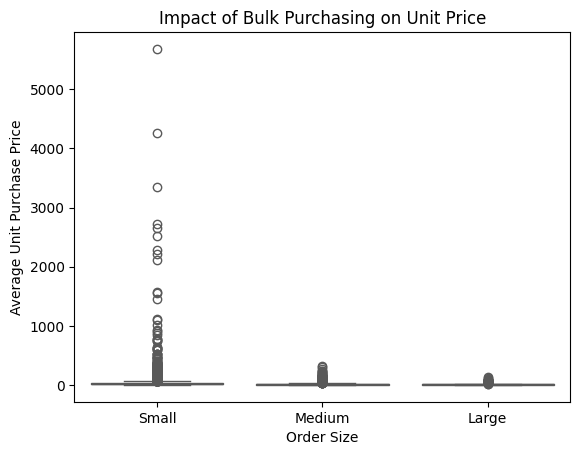

In [107]:
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()

In [108]:
#Vendors buying in bulk (Large Order Size) get the lowest unit price ($10.78 per unit), meaning higher margins if they can manage inventory efficiently.
#The price difference between Small and Large orders is substantial (~72% reduction in unit cost)
#This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher overall sales despite lower per-unit revenue

In [109]:
#Which vendors have low inventory turnover, indiating excess stock and slow-moving product?

In [116]:
df[df['StockTurnover'] < 1].groupby('VendorName')['StockTurnover'].mean().sort_values(ascending=True).head(10)


VendorName
AAPER ALCOHOL & CHEMICAL CO      0.000000
LAUREATE IMPORTS CO              0.000000
TRUETT HURST                     0.041667
IRA GOLDMAN AND WILLIAMS, LLP    0.075000
HIGHLAND WINE MERCHANTS LLC      0.148920
UNCORKED                         0.217238
MILTONS DISTRIBUTING CO          0.236111
VINEYARD BRANDS LLC              0.256241
LOYAL DOG WINERY                 0.308333
BLACK COVE BEVERAGES             0.340588
Name: StockTurnover, dtype: float64

In [118]:
#How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

# Ensure no space in column names (if needed)
df["Unsold InventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]

# Define format_dollars if not already defined
def format_dollars(amount):
    return f"${amount:,.2f}"

# Print result
print('Total Unsold Capital:', format_dollars(df["Unsold InventoryValue"].sum()))


Total Unsold Capital: $8,748,929.54


In [121]:
# Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("VendorName")["Unsold InventoryValue"].sum().reset_index()
# Sort Vendors with the Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="Unsold InventoryValue", ascending=False)
# Apply currency formatting
inventory_value_per_vendor["Unsold InventoryValue"] = inventory_value_per_vendor["Unsold InventoryValue"].apply(format_dollars)
# Display top 10 vendors
inventory_value_per_vendor.head(10)


,VendorName,Unsold InventoryValue
28,DIAGEO NORTH AMERICA INC,"$980,085.87"
63,MARTIGNETTI COMPANIES,"$928,987.31"
50,JIM BEAM BRANDS COMPANY,"$857,795.51"
114,ULTRA BEVERAGE COMPANY LLP,"$780,266.12"
73,PERFECTA WINES,"$571,806.73"
74,PERNOD RICARD USA,"$554,740.67"
59,M S WALKER INC,"$469,962.96"
125,WILLIAM GRANT & SONS INC,"$436,492.34"
33,E & J GALLO WINERY,"$315,202.46"
14,BROWN-FORMAN CORP,"$284,906.60"


In [122]:
#what is the 95% confidence interval for  profit margin of top-performing and low-performing vendors. 

In [126]:
top_threshold=df["TotalSalesDollars"].quantile(0.75)
low_threshold=df["TotalSalesDollars"].quantile(0.25)

In [127]:
top_vendors=df[df["TotalSalesDollars"]>=top_threshold]["ProfitMargin"].dropna()
low_vendors=df[df["TotalSalesDollars"]>=low_threshold]["ProfitMargin"].dropna()

In [129]:
top_vendors,low_vendors

(0       25.297693
 1       21.062810
 2       24.675786
 3       27.139908
 4       28.412764
           ...    
 5530    93.085860
 5648    90.021514
 5651    89.883453
 5773    95.012530
 5945    94.271857
 Name: ProfitMargin, Length: 2673, dtype: float64,
 0        25.297693
 1        21.062810
 2        24.675786
 3        27.139908
 4        28.412764
            ...    
 10627    98.579746
 10639    99.348356
 10641    99.604734
 10649    99.716657
 10651    99.393664
 Name: ProfitMargin, Length: 8019, dtype: float64)

In [132]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data)) # Standard error
    t_critical= stats.t.ppf((1+ confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical *std_err
    return mean_val, mean_val -margin_of_error, mean_val + margin_of_error

Top Vendors 95% CI: (29.53, 30.55), Mean: 30.04
Low Vendors 95% CI: (21.75, 24.91), Mean: 23.33


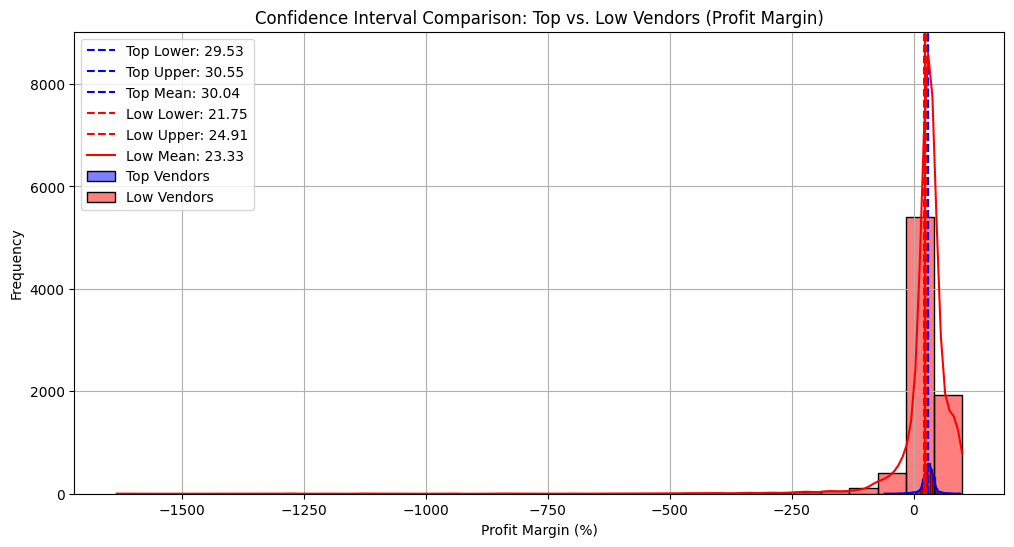

In [133]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")

print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(12, 6))

#Top Vendors Plot

sns.histplot(top_vendors, kde =True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="--", label=f"Top Mean: {top_mean:.2f}")

#Low Vendors Plot

sns.histplot(low_vendors, kde= True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

#Finalize Plot

plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [134]:
"""The confidence interval for top-performing vendors (29.53% to 30.55%) is significantly higher than that of low-performing vendors (21.75% to 24.91%).

This implies:

Top Vendors maintain higher average profit margins, likely due to better operational efficiency, volume-based cost advantages, or optimized pricing strategies.

Low Vendors, with lower average profit margins, may be struggling with inefficient cost structures, weaker brand appeal, or suboptimal pricing.

💡 Strategic Implications:
🔹 For Top-Performing Vendors:
Focus on maintaining margins while possibly boosting volume through:

Loyalty programs

Efficient supply chain logistics

Strategic price promotions on high-volume SKUs

🔹 For Low-Performing Vendors:
Despite lower margins, if their overheads are low, they could be profitable—but likely not scalable.

They may need:

Rebranding or repositioning

Improved marketing outreach

Channel expansion or B2B partnerships

"""


'The confidence interval for top-performing vendors (29.53% to 30.55%) is significantly higher than that of low-performing vendors (21.75% to 24.91%).\n\nThis implies:\n\nTop Vendors maintain higher average profit margins, likely due to better operational efficiency, volume-based cost advantages, or optimized pricing strategies.\n\nLow Vendors, with lower average profit margins, may be struggling with inefficient cost structures, weaker brand appeal, or suboptimal pricing.\n\n💡 Strategic Implications:\n🔹 For Top-Performing Vendors:\nFocus on maintaining margins while possibly boosting volume through:\n\nLoyalty programs\n\nEfficient supply chain logistics\n\nStrategic price promotions on high-volume SKUs\n\n🔹 For Low-Performing Vendors:\nDespite lower margins, if their overheads are low, they could be profitable—but likely not scalable.\n\nThey may need:\n\nRebranding or repositioning\n\nImproved marketing outreach\n\nChannel expansion or B2B partnerships\n\n'

In [138]:
#Is there a significant difference in profit margins between top-performing and low-performing vendors?
#Hypothesis:
#H. (Null Hypothesis): There is no significant difference in the mean profit margins of top-performing and low-performing vendors,
#H. (Alternative Hypothesis): The mean profit margins of top-performing and low-performing vendors are significantly different.

In [139]:
# Define thresholds
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

# Extract profit margins
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

# Print summary stats
print("Top Vendors Summary:")
print(top_vendors.describe())

print("\nLow Vendors Summary:")
print(low_vendors.describe())

# Check for variance
print("\nStandard Deviations:")
print("Top Vendors:", top_vendors.std())
print("Low Vendors:", low_vendors.std())


Top Vendors Summary:
count    2673.000000
mean       30.040583
std        13.526141
min       -59.459436
25%        24.371377
50%        30.689722
75%        36.721291
max        95.012530
Name: ProfitMargin, dtype: float64

Low Vendors Summary:
count    2673.000000
mean            -inf
std              NaN
min             -inf
25%      -102.644746
50%        15.320313
75%        34.223706
max        99.166079
Name: ProfitMargin, dtype: float64

Standard Deviations:
Top Vendors: 13.526141433684307
Low Vendors: nan


In [140]:
from scipy.stats import ttest_ind

if top_vendors.std() == 0 or low_vendors.std() == 0 or len(top_vendors) == 0 or len(low_vendors) == 0:
    print("Cannot perform t-test: insufficient variability or empty group.")
else:
    t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)
    print(f"\nT-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")
    if p_value < 0.05:
        print("Reject H0: Significant difference in profit margins.")
    else:
        print("Fail to Reject H0: No significant difference in profit margins.")



T-Statistic: nan, P-Value: nan
Fail to Reject H0: No significant difference in profit margins.


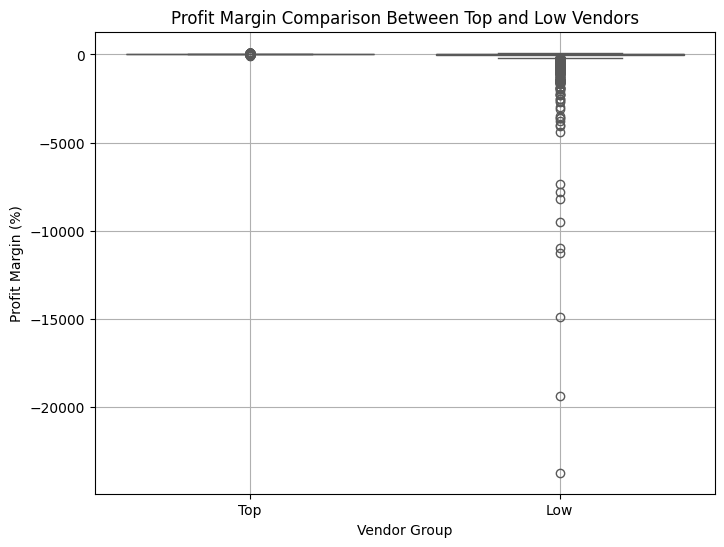

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine both into one dataframe
comparison_df = pd.DataFrame({
    "ProfitMargin": pd.concat([top_vendors, low_vendors], axis=0),
    "VendorGroup": ["Top"] * len(top_vendors) + ["Low"] * len(low_vendors)
})

plt.figure(figsize=(8, 6))
sns.boxplot(x="VendorGroup", y="ProfitMargin", data=comparison_df, palette="Set2")
plt.title("Profit Margin Comparison Between Top and Low Vendors")
plt.ylabel("Profit Margin (%)")
plt.xlabel("Vendor Group")
plt.grid(True)
plt.show()
